# Assignment 2: Regression & Classification Models

Using Heart Disease Dataset from the UCI Machine Learning Repository. 

Key features include age, sex, chest pain type, resting blood pressure, cholestrol, fasting blood sugar, maximum heart rate, & diagnosis of heart disease.

### Targets

Regression Model: predict cholestrol levels, from the column chol. 

Classification: predict the presence of heart disease as a binary classificatiton. 


In [25]:
#Import the necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.linear_model import ElasticNet


#Load the Heart Disease UCI Dataset

heart_data = pd.read_csv(r'C:\Users\simra\BINF-5507-Materials\Assignment_2\Data\heart_disease_uci(1).csv')

#Data Exploration
heart_data.head()

heart_data.info()

print(heart_data.isnull().sum())

# Calculate how many missing values for each column 
missing = heart_data.isnull().mean().sort_values(ascending=False)
print("Missing Values Percentage:")
print((missing * 100).round(2).astype(str) + '%')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       920 non-null    int64  
 1   sex       920 non-null    object 
 2   dataset   920 non-null    object 
 3   cp        920 non-null    object 
 4   trestbps  861 non-null    float64
 5   chol      890 non-null    float64
 6   fbs       830 non-null    object 
 7   restecg   918 non-null    object 
 8   thalch    865 non-null    float64
 9   exang     865 non-null    object 
 10  oldpeak   858 non-null    float64
 11  slope     611 non-null    object 
 12  ca        309 non-null    float64
 13  thal      434 non-null    object 
 14  num       920 non-null    int64  
dtypes: float64(5), int64(2), object(8)
memory usage: 107.9+ KB
age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak 

### Exploratory Analysis Conclusions

The dataset column indicates location where data is derived from, and is redundant as a feature. 

Some datatypes need to be changed, sex fbs and exang need to be changed to binary. 

Missing values need to be handled in the columns ca, thal, slope, fbs, oldpeak, trestbps, thalach, exang, chol & restecg. Ca and thal have more than 50% of missing values, so we may need to drop them. Chol is the target for linear, so we need to drop missing rows. Target for classification has no missing values. The remaining columns can be imputed. 


In [26]:
# Data Preprocessing

# Drop the dataset column as it is redundant. 
heart_data = heart_data.drop(columns=['dataset']) 


# Replace binary categorical variables to binary types
heart_data['sex'] = heart_data['sex'].replace({'Male': 1, 'Female': 0})
heart_data['fbs'] = heart_data['fbs'].replace({'True': 1, 'False': 0})
heart_data['exang'] = heart_data['exang'].replace({'Yes': 1, 'No': 0})


# One hot encoding needed for categorical variables with more than 2 categories for linear regression
# cp, restecg, slope, thal are categorical variables with more than 2
heart_data = pd.get_dummies(heart_data, columns=['cp', 'restecg', 'slope'], drop_first=True) 


# Drop columns with > 50% missing values. See if this improves model performance or not. - they do improve
heart_data = heart_data.drop(columns=['ca', 'thal'])

# Handle missing values

# Drop the rows with missing values in chol, as it is the target variable
heart_data = heart_data.dropna(subset=['chol']) 

# Impute numeric columns with mean
heart_data = heart_data.fillna(heart_data.mean(numeric_only=True)) 

# Impute the data in the binary columns with mode
binary_heart_data = ['sex', 'fbs', 'exang']
for col in binary_heart_data: 
    if heart_data[col].isnull().any():
        mode_val = heart_data[col].mode(dropna=True)[0]
        heart_data[col].fillna(mode_val, inplace=True)
        
# Impute the data in the categorical columns with mode
categorical_heart_data = heart_data.select_dtypes(include=['object', 'category']).columns
for col in categorical_heart_data: 
    mode_val = heart_data[col].mode(dropna=True)[0]
    heart_data[col].fillna(mode_val, inplace=True)


# Confirm that there are no missing values left 
print(heart_data.isnull().sum())

# Remove duplicate rows
heart_data= heart_data.drop_duplicates() #Removes duplicate rows from the dataset

# Normalize columns that are non-normal distribution; 
# try to normalize the data after evaluating model first to see if it improves performance
scaler = StandardScaler()
heart_data[['age', 'trestbps', 'thalch', 'oldpeak']] = scaler.fit_transform(heart_data[['age', 'trestbps', 'thalch', 'oldpeak']])



C:\Users\simra\AppData\Local\Temp\ipykernel_15264\2880741328.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  heart_data['sex'] = heart_data['sex'].replace({'Male': 1, 'Female': 0})
C:\Users\simra\AppData\Local\Temp\ipykernel_15264\2880741328.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  h

age                         0
sex                         0
trestbps                    0
chol                        0
fbs                         0
thalch                      0
exang                       0
oldpeak                     0
num                         0
cp_atypical angina          0
cp_non-anginal              0
cp_typical angina           0
restecg_normal              0
restecg_st-t abnormality    0
slope_flat                  0
slope_upsloping             0
dtype: int64


## Linear Regression Model to Predict Cholestrol Levels

Using R² and Root Mean Square Error (RMSE) as evaluation metrics and ElasticNet, experiment with varying regularization 
parameters (alpha and l1_ratio) and observe their effects on model coefficients and performance. 

Map the varying alpha and l1_ratios in a heatmap of the evaluation metrics R2 and RMSE 


c:\Users\simra\.pixi\envs\default\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.672e+06, tolerance: 9.133e+02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
c:\Users\simra\.pixi\envs\default\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.729e+06, tolerance: 9.133e+02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemente

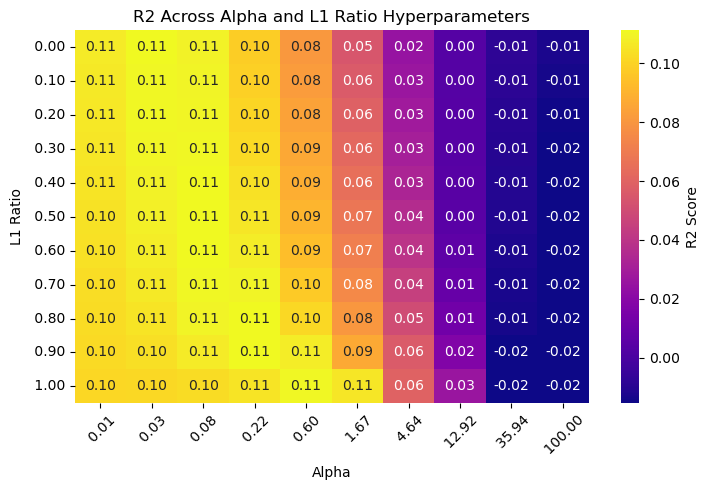

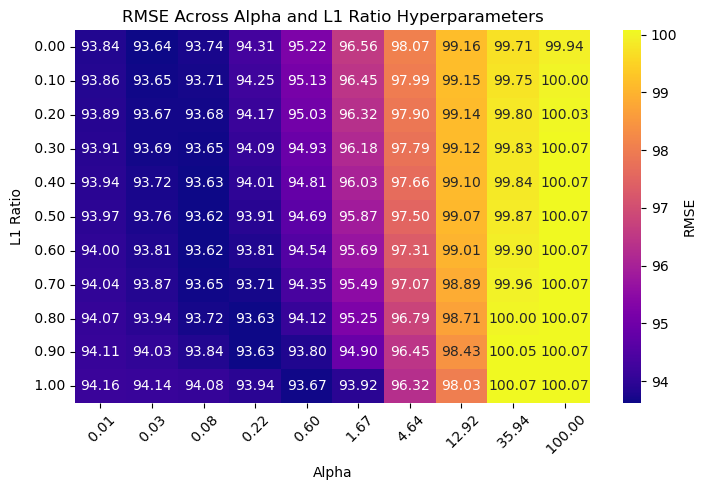

In [27]:
# Define the features and target
X = heart_data.drop(columns=['chol']) #dropping chol here as it is the target
y = heart_data['chol']

# Split the data into train/test (80/20 split).
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=67) #Seed is set at 67 for reproducibility


# Using numpy, create a grid for the hyperparameters -> because we want to evaluate various alpha & l1 ratios
alphas = np.logspace(-2, 2, 10) #goes from 0.01 to 100; spacing the numbers evenly on a logscale
l1_ratios = np.linspace(0, 1, 11) #goes from 0 -1 in 0.1 increments; linear scale

# Defines matrices to store the r2 and rmse scores for each configuration of l1_ratio and alpha
r2_matrix = pd.DataFrame(index = l1_ratios, columns = alphas) 
rmse_matrix = pd.DataFrame(index = l1_ratios, columns = alphas)

# Run the model using ElasticNet regularization, looping through the l1_ratio and alpha grids defined earlier. 

for l1 in l1_ratios: 
    for alpha in alphas:
        elastic_net_model = ElasticNet(alpha = alpha, l1_ratio = l1, max_iter=10000) 
        # alpha is set to each alpha value in the alhpas list, same for l1_ratio. Max iterations set to create an upper limit to stop convergence warnings (this ensures the model converges)
        elastic_net_model.fit(X_train, y_train) # use training set to fit the model
        elastic_net_pred = elastic_net_model.predict(X_test) # use x test to predict the y values (stored in elastic_net_pred)
        r2 = r2_score(y_test, elastic_net_pred) # r2 function returns r2 score of the model
        rmse = root_mean_squared_error(y_test, elastic_net_pred) # rmse function returns the root mean squared error of the model; can also use mse and root square it manually
        r2_matrix.loc[l1, alpha] = r2 # save r2 score into the r2_matrix dataframe
        rmse_matrix.loc[l1, alpha] = rmse # save rmse score into the rmse_matrix dataframe


# Convert values to float to graph it
r2_matrix = r2_matrix.astype(float)
rmse_matrix = rmse_matrix.astype(float)         
        
# Plot: create a heatmap of R2 and RMSE

#R2 Heatmap 
plt.figure(figsize= (14, 5))
plt.subplot(1, 2, 1)
sns.heatmap(r2_matrix, annot = True, fmt = ".2f", cmap = "plasma", cbar_kws={"label": "R2 Score"})
xticks = [f"{x: .2f}" for x in r2_matrix.columns] # defines the x-axis ticks with 2 decimal places
plt.xticks(ticks=np.arange(len(xticks)) + 0.5, labels = xticks, rotation = 45) # plots the x-axis ticks at the center of each cell and rotates them 45 degrees for better visibility
yticks = [f"{y: .2f}" for y in r2_matrix.index] # defines the y-axis ticks with 2 decimal places
plt.yticks(ticks=np.arange(len(yticks)) + 0.5, labels = yticks, rotation = 0) # plots the y-axis ticks at the center of each cell; no rotation needed
plt.title("R2 Across Alpha and L1 Ratio Hyperparameters")
plt.xlabel("Alpha")
plt.ylabel("L1 Ratio")
plt.tight_layout()
plt.show()

#RMSE Heatmap
plt.figure(figsize= (14, 5))
plt.subplot(1, 2, 1)
sns.heatmap(rmse_matrix, annot = True, fmt = ".2f", cmap = "plasma", cbar_kws={"label": "RMSE"})
xticks = [f"{x: .2f}" for x in rmse_matrix.columns]
plt.xticks(ticks=np.arange(len(xticks)) + 0.5, labels = xticks, rotation = 45)
yticks = [f"{y: .2f}" for y in rmse_matrix.index]
plt.yticks(ticks=np.arange(len(yticks)) + 0.5, labels = yticks, rotation = 0)
plt.title("RMSE Across Alpha and L1 Ratio Hyperparameters")
plt.xlabel("Alpha")
plt.ylabel("L1 Ratio")
plt.tight_layout()
plt.show()

### Optimal L1 Ratio & Alpha Configuration

The optimal (lowest) RMSE is achieved at an L1 ratio of 0.5 & 0.6 and alpha of 0.08, while the optimal (higher) R2 Score is achieved at an L1 ratio of 0 - 1 and alpha of 0.01 - 1.67. The optimal configuration should reflect a higher R2 score and low RMSE, and so an alpha of 0.08 and l1 ratio of 0.5 or 0.6 balance both these metrics. 


## Classification: Logistic Regression & k-NN Classifiers To Predict Heart Disease Presence

Training and evaluating logistic regression and k-NN classifiers to predict heart disease presence as a binary classification task. 

Using accuracy, F1 score, AUROC, and AUPRC as evaluation metrics, experiment with hyperparameters for each type - penalty and solver for logistic regression and k-neighbours for k-NN to observe their effects on model coefficients and performance.

Plot AUROC and AUPRC curves for the model’s best configuration.

In [28]:
# Take a closer look at num (heart disease severity) column
heart_data['num'].value_counts()

# The target 'num' has 5 categories; 0 is the absence of heart disease and 1-4 is the severity. Must convert to binary for binary classification task 
heart_data['num'] = heart_data['num'].apply(lambda x: 1 if x > 0 else 0) # separates 0 into one category & anything greater than 0 to the second category

heart_data['num'].value_counts() # Check if column was separated into binary successfully


num
1    497
0    392
Name: count, dtype: int64

In [29]:

# Import libraries for logistic regression & k-NN
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_recall_curve, average_precision_score, roc_auc_score, f1_score


# Define X & y -> features and target
X = heart_data.drop(columns=['num'])  # Features
y = heart_data['num']  # Target variable that has been classified to binary


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=67, stratify=y) #80/20 split for training and testing set; seed set to 67; stratify for proportional split

# Train a bunch of log regs with varying penalty and solver combinations; c is consistently set to 0.001 & maximum iterations are consistent
# Penalty is the regularization term, solver is the optimization algorithm

# Penalty: l2, Solver: liblinear
log_reg1 = LogisticRegression(penalty = 'l2', solver = 'liblinear', C = 0.001, random_state=67, max_iter=10000) 
log_reg1.fit(X_train, y_train)
y_pred1 = log_reg1.predict(X_test)
y_proba1 = log_reg1.predict_proba(X_test)[:, 1]  # Get the predicted probabilities for the positive class    

# Penalty: l2, Solver: sag
log_reg2= LogisticRegression(penalty = 'l2', solver = 'sag', C = 0.001, random_state=67, max_iter=10000) 
log_reg2.fit(X_train, y_train)
y_pred2 = log_reg2.predict(X_test)
y_proba2 = log_reg2.predict_proba(X_test)[:, 1]

# Penalty: l1, Solver: liblinear
log_reg3 = LogisticRegression(penalty = 'l1', solver = 'liblinear', C = 0.001, random_state=67, max_iter=10000)
log_reg3.fit(X_train, y_train)
y_pred3 = log_reg3.predict(X_test)
y_proba3 = log_reg3.predict_proba(X_test)[:, 1]

# Penalty: l1, Solver: saga
log_reg4 = LogisticRegression(penalty = 'l1', solver = 'saga', C = 0.001, random_state=67, max_iter=10000) 
log_reg4.fit(X_train, y_train)
y_pred4 = log_reg4.predict(X_test)
y_proba4 = log_reg4.predict_proba(X_test)[:, 1]

# Penalty: elasticnet, Solver: saga
log_reg5 = LogisticRegression(penalty = 'elasticnet', solver = 'saga', l1_ratio = 0.5, C = 0.001, random_state=67, max_iter=10000) 
log_reg5.fit(X_train, y_train)
y_pred5 = log_reg5.predict(X_test)
y_proba5 = log_reg5.predict_proba(X_test)[:, 1]

# Penalty: none, Solver: lbfgs
log_reg6 = LogisticRegression(solver = 'lbfgs', C = 0.001, random_state=67, max_iter=10000) 
log_reg6.fit(X_train, y_train)
y_pred6 = log_reg6.predict(X_test)
y_proba6 = log_reg6.predict_proba(X_test)[:, 1]

# Penalty: none, Solver: saga
log_reg7 = LogisticRegression(solver = 'saga', C = 0.001, random_state=67, max_iter=10000) 
log_reg7.fit(X_train, y_train)
y_pred7 = log_reg7.predict(X_test)
y_proba7 = log_reg7.predict_proba(X_test)[:, 1]

# Penalty: l2, Solver: lbfgs
log_reg8 = LogisticRegression(penalty = 'l2', solver = 'lbfgs', C = 0.001, random_state=67, max_iter=10000) 
log_reg8.fit(X_train, y_train)
y_pred8 = log_reg8.predict(X_test)
y_proba8 = log_reg8.predict_proba(X_test)[:, 1]

# Penalty: l2, Solver: saga
log_reg9 = LogisticRegression(penalty = 'l2', solver = 'saga', C = 0.001, random_state=67, max_iter=10000) 
log_reg9.fit(X_train, y_train)
y_pred9 = log_reg9.predict(X_test)
y_proba9 = log_reg9.predict_proba(X_test)[:, 1]

# Penalty: l2, Solver: newton-cg
log_reg10 = LogisticRegression(penalty = 'l2', solver = 'newton-cg', C = 0.001, random_state=67, max_iter=10000) 
log_reg10.fit(X_train, y_train)
y_pred10 = log_reg10.predict(X_test)
y_proba10 = log_reg10.predict_proba(X_test)[:, 1]


# Define a function for evaluation because we need to repeat it a lot

def evaluation(name, y_true, y_pred, y_proba):
    print(f"Model: {name}")
    print(f"Accuracy: {accuracy_score(y_true, y_pred)}") # Accuracy score
    print(f"F1 Score: {f1_score(y_true, y_pred)}") # F1 Score
    print(f"AUROC: {roc_auc_score(y_true, y_proba)}") # Area under the curve (using sklearn function)
    print(f"AUPRC: {average_precision_score(y_true, y_proba)}") # average precision score - used as representation of AUPRC
    print("\n")
    
#Print each combination    
evaluation("Logistic Regression 1", y_test, y_pred1, y_proba1)  
evaluation("Logistic Regression 2", y_test, y_pred2, y_proba2)
evaluation("Logistic Regression 3", y_test, y_pred3, y_proba3)
evaluation("Logistic Regression 4", y_test, y_pred4, y_proba4)
evaluation("Logistic Regression 5", y_test, y_pred5, y_proba5)
evaluation("Logistic Regression 6", y_test, y_pred6, y_proba6)
evaluation("Logistic Regression 7", y_test, y_pred7, y_proba7)
evaluation("Logistic Regression 8", y_test, y_pred8, y_proba8)
evaluation("Logistic Regression 9", y_test, y_pred9, y_proba9)
evaluation("Logistic Regression 10", y_test, y_pred10, y_proba10)

      


Model: Logistic Regression 1
Accuracy: 0.7921348314606742
F1 Score: 0.8102564102564103
AUROC: 0.8716666666666667
AUPRC: 0.8955631580033325


Model: Logistic Regression 2
Accuracy: 0.797752808988764
F1 Score: 0.8163265306122449
AUROC: 0.8747435897435897
AUPRC: 0.9006782625936435


Model: Logistic Regression 3
Accuracy: 0.43820224719101125
F1 Score: 0.0
AUROC: 0.5
AUPRC: 0.5617977528089888


Model: Logistic Regression 4
Accuracy: 0.5617977528089888
F1 Score: 0.7194244604316546
AUROC: 0.5
AUPRC: 0.5617977528089888


Model: Logistic Regression 5
Accuracy: 0.5617977528089888
F1 Score: 0.7194244604316546
AUROC: 0.5
AUPRC: 0.5617977528089888


Model: Logistic Regression 6
Accuracy: 0.7134831460674157
F1 Score: 0.7536231884057971
AUROC: 0.8065384615384615
AUPRC: 0.8543241487191906


Model: Logistic Regression 7
Accuracy: 0.797752808988764
F1 Score: 0.8163265306122449
AUROC: 0.8748717948717949
AUPRC: 0.9006795184683745


Model: Logistic Regression 8
Accuracy: 0.7134831460674157
F1 Score: 0.7536

### Top Performing Penalty & Solver Configuration

Three different penalty & solver configurations have the optimal evaluation metrics. Logistic regression 2, 7 and 9 all show equal performance, with the highest accuracy, along with F1 scores, AUROC and AUPRC. These configurations are:

Logistic Regression 2: penalty - l2 and solver sag

Logistic Regression 7: penalty - none and solver saga

Logistic Regression 9: penalty - l2 and solver saga

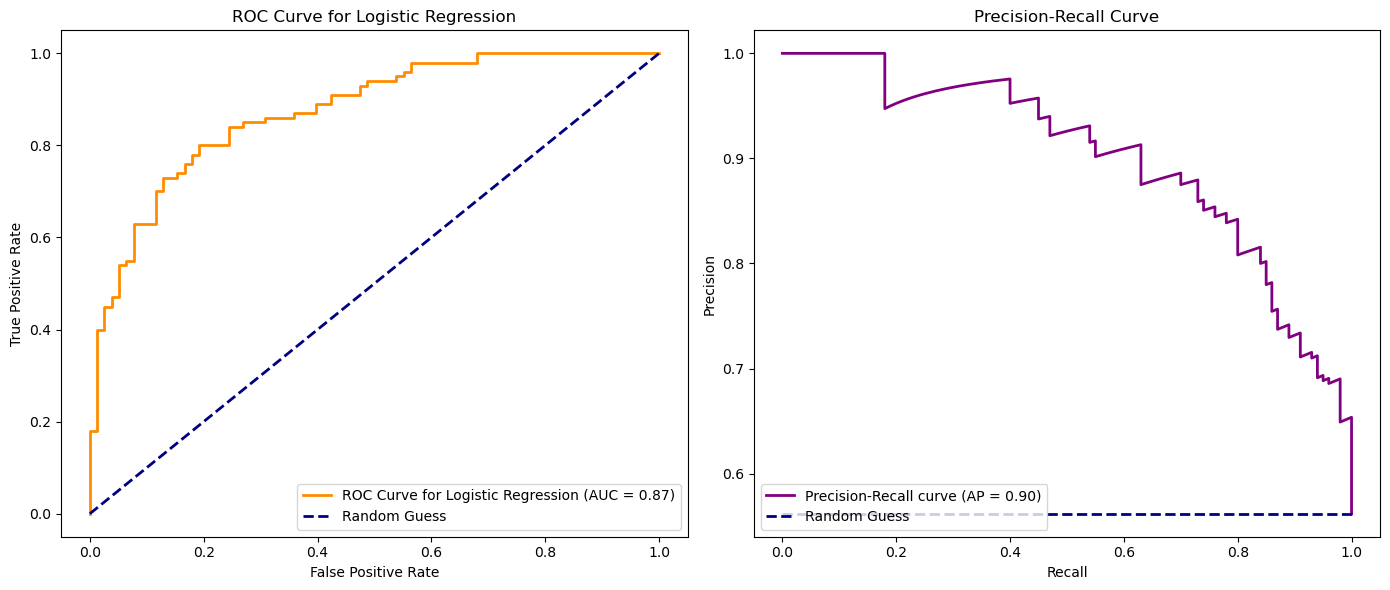

In [30]:

# ROC & Precision-Recall Plots for Logistic Regression 9: Penalty - l2 & solver saga

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_proba9) # Using the predicted probabilities for the positive class
roc_auc = auc(fpr, tpr) 

# Compute Precision-Recall curve and PR area
precision, recall, _ = precision_recall_curve(y_test, y_proba9)
average_precision = average_precision_score(y_test, y_proba9)

# Plot ROC curve and Precision-Recall curve as subplots on the same figure
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot ROC curve
axes[0].plot(fpr, tpr, color='darkorange', lw=2, label='AUROC (AUC = %0.2f)' % roc_auc)
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve for Logistic Regression (Penalty - l2; Solver - saga)')
axes[0].legend(loc='lower right')

positive_class = y_test.mean() # Calculate the rate of the positive class in the test set

# Plot Precision-Recall curve
axes[1].plot(recall, precision, color='purple', lw=2, label='AUPRC (AP = %0.2f)' % average_precision)
axes[1].plot([0,1],[positive_class, positive_class], color='navy', lw=2, linestyle='--', label='Random Guess')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve for Logistic Regression (Penalty - l2; Solver - saga)')
axes[1].legend(loc='lower left')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

### KNN

Tune the n_neighbors hyperparameter and the impact on evaluation metrics. Plot the best configuration for the model.

In [37]:

from sklearn.neighbors import KNeighborsClassifier 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# K - nearest neighbours
# loop through n-neighbours 1 - 10 for each model trained.
for k in range(1, 11): # For loop to iterate through range of k neighbours
    knn = KNeighborsClassifier(n_neighbors=k, metric='manhattan') #set n-neighbours to k (range); metric to manhattan
    knn.fit(X_train, y_train) #x_train, x_test, y-train and y_test defined earlier in train-test split for logistic regression 
    y_pred_knn = knn.predict(X_test)
    y_proba_knn = knn.predict_proba(X_test)[:, 1]
    
    evaluation(f"KNN (n-neighbors = {k})", y_test, y_pred_knn, y_proba_knn) #Use evaluation function defined earlier to produce evaluation metrics

#Grid search to evaluate best configuration
param_grid_knn = {'n_neighbors': range(1,11),'metric': ['manhattan']} #keep metric consistent

grid_search_knn = GridSearchCV(
    KNeighborsClassifier(), 
    param_grid_knn, 
    scoring = {
        'accuracy': 'accuracy', 
        'f1': 'f1',
        'roc_auc': 'roc_auc', 
        'average_precision': make_scorer(average_precision_score)
        }, 
        refit = 'f1', 
        cv =5,
        return_train_score=True
)


# grid_search_knn = GridSearchCV(
#     KNeighborsClassifier(), 
#     param_grid_knn, 
#     scoring = {
#         'accuracy': 'accuracy', 
#         'f1': 'f1',
#         'roc_auc': 'roc_auc', 
#         'average_precision': make_scorer(average_precision_score)
#         }, 
#         refit = 'roc_auc', 
#         cv =5,
#         return_train_score=True
# )

grid_search_knn.fit(X_train, y_train)

Model: KNN (n-neighbors = 1)
Accuracy: 0.6966292134831461
F1 Score: 0.7244897959183674
AUROC: 0.6947435897435899
AUPRC: 0.6880255149812735


Model: KNN (n-neighbors = 2)
Accuracy: 0.6573033707865169
F1 Score: 0.6211180124223602
AUROC: 0.7561538461538461
AUPRC: 0.7426486213076746


Model: KNN (n-neighbors = 3)
Accuracy: 0.7471910112359551
F1 Score: 0.7668393782383419
AUROC: 0.7667307692307692
AUPRC: 0.757781541149203


Model: KNN (n-neighbors = 4)
Accuracy: 0.7078651685393258
F1 Score: 0.6976744186046512
AUROC: 0.7922435897435898
AUPRC: 0.7813676231911955


Model: KNN (n-neighbors = 5)
Accuracy: 0.7696629213483146
F1 Score: 0.7897435897435897
AUROC: 0.8150641025641026
AUPRC: 0.8246710036883699


Model: KNN (n-neighbors = 6)
Accuracy: 0.7584269662921348
F1 Score: 0.7624309392265194
AUROC: 0.8262820512820512
AUPRC: 0.8343312089634206


Model: KNN (n-neighbors = 7)
Accuracy: 0.7640449438202247
F1 Score: 0.79
AUROC: 0.8403205128205129
AUPRC: 0.8516832526518622


Model: KNN (n-neighbors = 8)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['manhattan'], 'n_neighbors': range(1, 11)},
             refit='f1', return_train_score=True,
             scoring={'accuracy': 'accuracy',
                      'average_precision': make_scorer(average_precision_score, response_method='predict'),
                      'f1': 'f1', 'roc_auc': 'roc_auc'})

### Optimal N Neighbor Configuration

As the number of k neighbors increases, most of the evaluation metrics also increase, however this might not reflect an optimization of the model - we are simply increasing the size of the nighbourhood . Grid search suggests that n-neighbors of 3 is the optimal configuration (based on f1 score), and each of the evaluation metrics are decently high for this configuration. 

When using AUROC with grid search, it suggests that a k of 9 neighbors is the optimal configuration. This may be too high of a configuration though, which may reduce the sensitivity of the model to micro-patterns. In my judgement, k-neighbors of 6 finds a good balance between the two conclusions and all the evaluation metrics. 

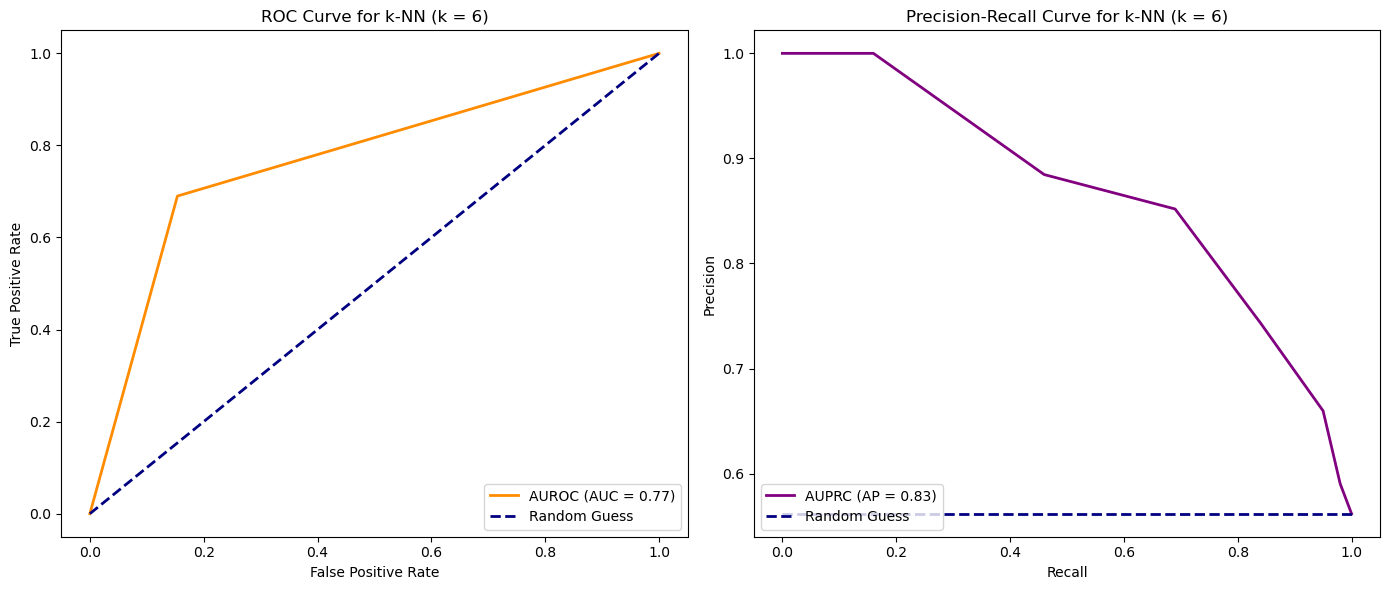

In [39]:
# Train the model with the best configuratin k -> 6

best_knn = KNeighborsClassifier(n_neighbors= 6, metric='manhattan') #set n-neighbours to 6; metric to manhattan
best_knn.fit(X_train, y_train) #x_train, x_test, y-train and y_test defined earlier in train-test split for logistic regression 
y_pred_best = best_knn.predict(X_test)
y_proba_best = best_knn.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred_best) # Using the predicted probabilities for the positive class
roc_auc = auc(fpr, tpr) 

# Compute Precision-Recall curve and PR area
precision, recall, _ = precision_recall_curve(y_test, y_proba_best)
average_precision = average_precision_score(y_test, y_proba_best)

# Plot ROC curve and Precision-Recall curve as subplots on the same figure
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot ROC curve
axes[0].plot(fpr, tpr, color='darkorange', lw=2, label='AUROC (AUC = %0.2f)' % roc_auc)
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve for k-NN (k = 6)')
axes[0].legend(loc='lower right')

positive_class = y_test.mean() # Calculate the rate of the positive class in the test set

# Plot Precision-Recall curve
axes[1].plot(recall, precision, color='purple', lw=2, label='AUPRC (AP = %0.2f)' % average_precision)
axes[1].plot([0,1],[positive_class, positive_class], color='navy', lw=2, linestyle='--', label='Random Guess')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve for k-NN (k = 6)')
axes[1].legend(loc='lower left')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()
